In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
latent_dim = 2
data_dim = 2
hidden_dim = 64
lr = 0.001
num_epochs = 50000
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
# Generate real data (points in a circle)
def generate_real_data(num_samples):
    angles = np.random.uniform(0, 2 * np.pi, num_samples)
    radius = 1.0
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    data = np.stack([x, y], axis=1)
    return torch.tensor(data, dtype=torch.float32)

In [34]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, data_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, data_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)


In [35]:
# Initialize generator and discriminator
generator = Generator(latent_dim, data_dim, hidden_dim).to(device)
discriminator = Discriminator(data_dim, hidden_dim).to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

In [36]:
# Training loop
for epoch in range(num_epochs):
    # Train Discriminator
    real_data = generate_real_data(batch_size).to(device)
    z = torch.randn(batch_size, latent_dim).to(device)  
    fake_data = generator(z).detach() 

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_data), real_labels)
    fake_loss = criterion(discriminator(fake_data), fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Train Generator (reuse the same z)
    optimizer_g.zero_grad()
    fake_data = generator(z)  # Same latent vector z used here
    g_loss = criterion(discriminator(fake_data), real_labels)  # Labels as real
    g_loss.backward()
    optimizer_g.step()

    # Logging
    if epoch % 500 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [0/50000] | D Loss: 1.3706 | G Loss: 0.6995
Epoch [500/50000] | D Loss: 0.9256 | G Loss: 1.3947
Epoch [1000/50000] | D Loss: 2.3357 | G Loss: 0.3006
Epoch [1500/50000] | D Loss: 1.2919 | G Loss: 0.8571
Epoch [2000/50000] | D Loss: 1.3567 | G Loss: 0.6578
Epoch [2500/50000] | D Loss: 0.7255 | G Loss: 1.3687
Epoch [3000/50000] | D Loss: 1.2993 | G Loss: 1.2979
Epoch [3500/50000] | D Loss: 1.4608 | G Loss: 0.7829
Epoch [4000/50000] | D Loss: 1.3048 | G Loss: 0.7694
Epoch [4500/50000] | D Loss: 1.2835 | G Loss: 0.7968
Epoch [5000/50000] | D Loss: 1.3150 | G Loss: 0.7554
Epoch [5500/50000] | D Loss: 1.2977 | G Loss: 0.7591
Epoch [6000/50000] | D Loss: 1.3557 | G Loss: 0.7164
Epoch [6500/50000] | D Loss: 1.3191 | G Loss: 0.7398
Epoch [7000/50000] | D Loss: 1.3405 | G Loss: 0.7612
Epoch [7500/50000] | D Loss: 1.2783 | G Loss: 0.7191
Epoch [8000/50000] | D Loss: 1.2934 | G Loss: 0.7715
Epoch [8500/50000] | D Loss: 1.3711 | G Loss: 0.7903
Epoch [9000/50000] | D Loss: 1.3153 | G Loss: 0.72

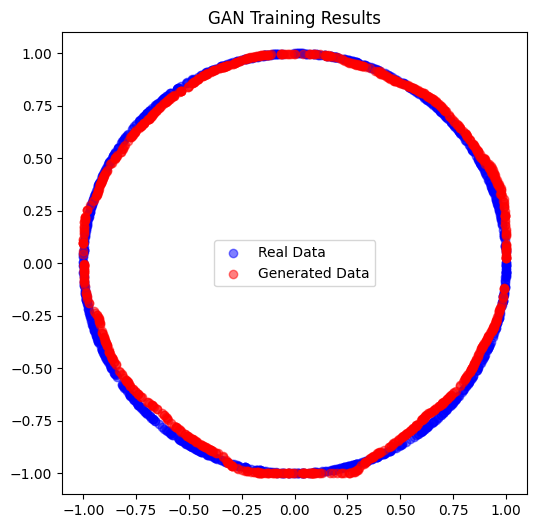

In [37]:
# Visualize generated data
z = torch.randn(1000, latent_dim).to(device)
generated_data = generator(z).cpu().detach().numpy()
real_data = generate_real_data(1000).numpy()

plt.figure(figsize=(6, 6))
plt.scatter(real_data[:, 0], real_data[:, 1], color="blue", alpha=0.5, label="Real Data")
plt.scatter(generated_data[:, 0], generated_data[:, 1], color="red", alpha=0.5, label="Generated Data")
plt.legend()
plt.title("GAN Training Results")
plt.show()
